<a href="https://colab.research.google.com/github/selvanath-a/ML-repo/blob/master/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
tf.executing_eagerly()

     |████████████████████████████████| 348.9MB 49kB/s 
     |████████████████████████████████| 3.1MB 42.3MB/s 
     |████████████████████████████████| 501kB 44.3MB/s 


True

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import matplotlib.pyplot as plt
import numpy as np
import time 
# import functools
import IPython.display as display


In [0]:
content_path=tf.keras.utils.get_file('puppy.jpg','https://i.kinja-img.com/gawker-media/image/upload/s--HqfzgkTd--/c_scale,f_auto,fl_progressive,q_80,w_800/wp2qinp6fu0d8guhex9v.jpg')
style_path=tf.keras.utils.get_file('scenery.jpg','https://images-na.ssl-images-amazon.com/images/I/81NIb8HRXkL._SL1500_.jpg')

# content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
# style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [0]:
path_to_img=content_path
max_dim=512


In [0]:
def load_img(path_to_img,crop=False):
  max_dim=512
  img=tf.io.read_file(path_to_img)
  img=tf.image.decode_jpeg(img,channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)
  
  shape=tf.cast(tf.shape(img)[:-1],tf.float32)
  scale=max_dim/max(shape)
  new_shape=tf.cast(scale*shape,tf.int32)
  img=tf.image.resize(img,new_shape)  
  
  img=img[tf.newaxis,:]
  if(crop):
    img=tf.image.crop_and_resize(img,boxes=[[0.118,0.1,0.87,0.9]],box_indices=[0],crop_size=[358,512])  
  return img

def imshow(image,title=None):
  if len(tf.shape(image))>3:
    image=tf.squeeze(image,axis=0)
  plt.imshow(image)  
  if(title):
    plt.title(title)

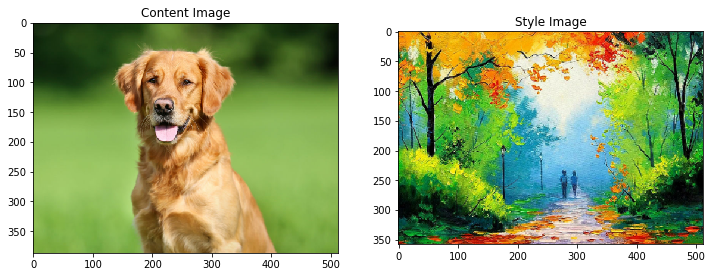

In [36]:
content_image=load_img(content_path)
style_image=load_img(style_path,True)
plt.subplot(1,2,1)
imshow(content_image,'Content Image')
plt.subplot(1,2,2)
imshow(style_image,'Style Image')

In [10]:
img=style_image
x=tf.keras.applications.vgg19.preprocess_input(img*255)
x=tf.image.resize(x,(224,224))
vgg=tf.keras.applications.VGG19(include_top=True,weights='imagenet')
r=vgg(x)

574717952/574710816 [==============================] - 17s 0us/step


In [24]:
labels_path=tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels=np.array(open(labels_path).read().splitlines())
labels[np.argsort(r)[0,::-1][:5]+1]

array(['fountain', 'church', 'castle', 'altar', 'barn'], dtype='<U30')

In [0]:
vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
# for layer in vgg.layers:
#   print(layer.name)
content_layers=['block5_conv2']
style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
num_content_layers=len(content_layers)
num_style_layers=len(style_layers)

In [0]:
def vgg_layers(layer_names):
  vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
  vgg.trainable=False
  model=tf.keras.Model([vgg.input],[vgg.get_layer(name).output for name in layer_names])
  return model

# style_extractor=vgg_layers(style_layers)
# style_outputs=style_extractor(style_image*255)

In [0]:
def gram_mat(input_tensor):
  result=tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  ij=tf.shape(input_tensor)[1]*tf.shape(input_tensor)[2]
  ij=tf.cast(ij,tf.float32)
  result/=ij
  return result

def process_style_content(image,style_layers=style_layers,content_layers=content_layers,vgg=vgg):
#   vgg=vgg_layers(style_layers+content_layers)
#   vgg.trainable=False
  
  input=tf.keras.applications.vgg19.preprocess_input(image*255)
  output=vgg(input)
   
#   num_style_layers=len(style_layers)
  style_outputs,content_outputs=(output[:num_style_layers],output[num_style_layers:])
  style_outputs=[gram_mat(style_output) for style_output in style_outputs]
  
  style_dict={name:output for name,output in zip(style_layers,style_outputs)}
  content_dict={name:output for name,output in zip(content_layers,content_outputs)}
  
  return {'content':content_dict,'style':style_dict}
  

In [40]:
vgg=vgg_layers(style_layers+content_layers)
results=process_style_content(content_image,style_layers,content_layers,vgg)

print('Styles:')
for name,output in results['style'].items():
  print(name)
  print(output.numpy().shape)
print('Content:')
for name,output in results['content'].items():
  print(name)
  print(output.numpy().shape)  
  results['content']



Styles:
block1_conv1
(1, 64, 64)
block2_conv1
(1, 128, 128)
block3_conv1
(1, 256, 256)
block4_conv1
(1, 512, 512)
block5_conv1
(1, 512, 512)
Content:
block5_conv2
(1, 24, 32, 512)


In [0]:
style_target=process_style_content(style_image,vgg=vgg)['style']
content_target=process_style_content(content_image,vgg=vgg)['content']
def clip_0_1(image):
  return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)
optimizer =tf.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)
content_weights=1e4
style_weights=1e-2

In [0]:


def style_content_loss(outputs):
  style_outputs=outputs['style']
  content_outputs=outputs['content']
  
  style_loss=tf.add_n([tf.reduce_mean((style_outputs[name]-style_target[name])**2) for name in style_outputs.keys()])
  
  style_loss*=style_weights/num_style_layers
  
  content_loss=tf.add_n([tf.reduce_mean((content_outputs[name]-content_target[name])**2) for name in content_outputs.keys()])
  
  content_loss*=content_weights/num_content_layers
  
  return (content_loss+style_loss)
  


In [0]:
def high_pass_x_y(image):
  x_del=image[:,:,1:,:]-image[:,:,:-1,:]
  y_del=image[:,1:,:,:]-image[:,:-1,:,:]
  return x_del,y_del

def total_variation_loss(image):
  x_del,y_del=high_pass_x_y(image)
  return tf.reduce_mean(x_del**2)+tf.reduce_mean(y_del**2)

total_variation_weight=1e8

# @tf.function
def train_step(image,var_loss=True):
  with tf.GradientTape() as tape:
    outputs=process_style_content(image,vgg=vgg)
    loss=style_content_loss(outputs)
    if(var_loss):
      loss+=total_variation_weight*total_variation_loss(image)
    
    
  grad=tape.gradient(loss,image)
  optimizer.apply_gradients([(grad,image)])
  image.assign(clip_0_1(image))
  

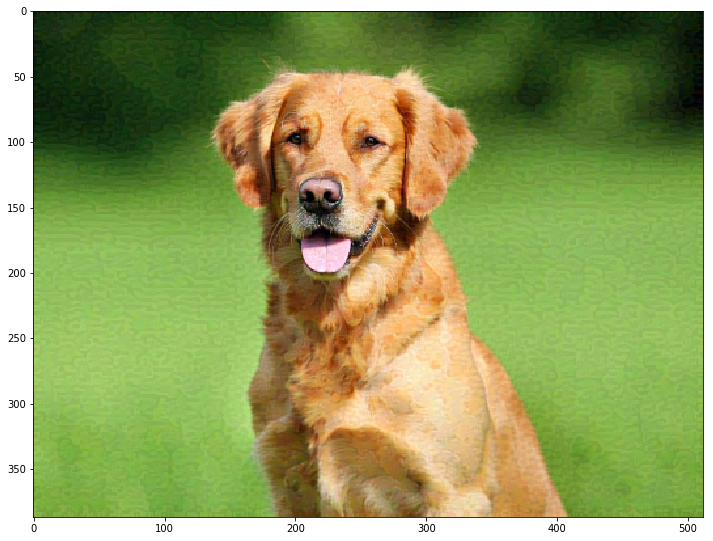

In [44]:
image=tf.Variable(content_image)
train_step(image)
train_step(image)
train_step(image)
imshow(image)

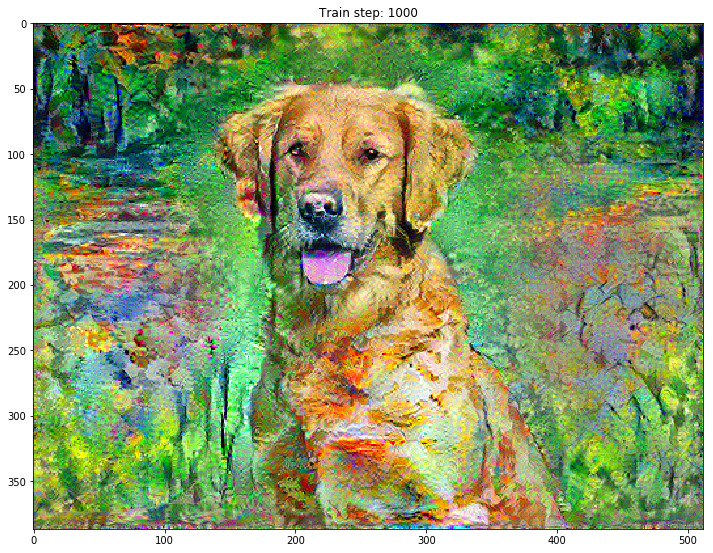

Total time: 135.5


In [42]:
image=tf.Variable(content_image)
epochs=10
steps_per_epoch=100
start = time.time()

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image,False)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image)
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))    

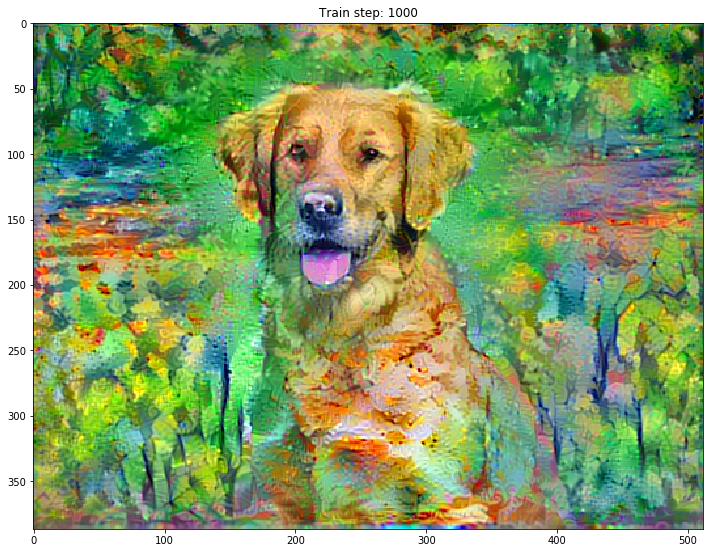

Total time: 142.2


In [43]:
image=tf.Variable(content_image)
epochs=10
steps_per_epoch=100
start = time.time()

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image)
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))    

In [0]:

plt.subplot(2,2,1)
imshow(clip_0_1(2*y_delta+0.5))

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_delta+0.5))

x_delta,y_delta=high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_delta+0.5))

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_delta+0.5))

